# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

Capstone Project</br>
<a href='https://www.udacity.com/course/data-scientist-nanodegree--nd025' target='blank'>Udacity Data Scientist Nanodegree</a>

</br>

<em>Initial Ideas and Data provided by: Arvato Financial Services</em>

## Table of Contents:
1. [Project Definition](#definition)
2. [Data Analysis](#analysis)
    1. [Get to Know the Data](#Get_to_Know_the_Data)
    2. [Useful Functions](#Useful_Functions)
    3. [Data Exploration](#Data_Exploration)
    4. [Missing Values](#Missing_Values)
    5. [Transformation](#Transformation)
3. [Customer Segmentation Report](#Segmentation)
    1. [PCA](#PCA)
    2. [KMeans Clustering](#Clustering)
4. [Supervised Learning Model](#Model)
    1. [Load and Clean](#Load)
    2. [Choosing the right Classifier](#Classifier)
    3. [GridSearchCV](#GridSearchCV)
    4. [Feature Importance](#Importance)
5. [Kaggle Competition](#Kaggle)
6. [Conclusion](#conclusion)
7. [Appendix](#appendix)

## 2. Project Definition <a class="anchor" id="definition"></a> 

#### Overview

The aim of this project is to create a model that predicts the probability of a person becoming a customer at a mail order company in Germany. The first part of the project was the analysis of the provided data and the visualisation of important and relevant information. Then, unsurpervised learning techniques such as Principal Component Analysis (PCA) and k Means Clustering were used to compare and cluster the two populations of existing customers and the general population of Germany.

The last part of the exercise was to create a suitable model to predict whether a person is likely to become a customer or not. In other words, to determine whether it is worthwhile to run a marketing campaign for that particular potential customer. 

The model was then tested with a test data set and submitted to Kaggle.

#### Problem Statement

The first problem to solve is to find out how the population of existing customers differs from the rest of the German population based on demographic information. To solve this part, the data must first be cleaned and scaled, and then it is necessary to form clusters.

For the second problem, it is crucial to find the most suitable classifier among many others, validate its results and finally optimise its parameters to achieve the best possible predictions.

#### Metrics

The evaluation measure for the model is AUC for the ROC curve, related to mail-order company customer detection. A Receiver Operating Characteristic (ROC) is a graph in which the true positive rate is plotted against the false positive rate.

## 2. Data Analysis <a class="anchor" id="analysis"></a> 

### 2.A Get to Know the Data <a class="anchor" id="Get_to_Know_the_Data"></a> 

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [132]:
# As a first step, decide if you need to run everything or if the output of the computationally intensive code is already
# stored in a pickle file

# If there is already a pickle file, then set the information below to False (not necessary for execution)

load_origin_data = False # name of pickle files: azdias.pkl, customers.pkl

gridsearch_key = False # name of pickle file: cv_gbc.pkl

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, learning_curve, ShuffleSplit, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn import metrics

%matplotlib inline

In [43]:
# load in the data (if necessary)
if load_origin_data:
    azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';', low_memory=False)
    customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';', low_memory=False)

    # removing 'Unnamed: 0'
    azdias.drop('Unnamed: 0', axis=1, inplace=True)
    customers.drop('Unnamed: 0', axis=1, inplace=True)
    
    # save as pickle file
    azdias.to_pickle('azdias.pkl')
    customers.to_pickle('customers.pkl')

In [44]:
azdias = pd.read_pickle('azdias.pkl')
customers = pd.read_pickle('customers.pkl')

### 2.B Useful Functions <a class="anchor" id="Useful_Functions"></a> 

In [45]:
def replace_by_nan(df, indicator_dict):
    '''
    This function replace the entries of the attributes by nan if 
    the attribute is listed as a key in the corresponding dictionary.
    
    input: df            : dataframe that needs to be cleaned
           indicator_dict: dictionary with key occuring as features in the df
    
    output:
           dataframe with entries replaced by np.nan if they were listed as values in the dict
    '''
    
    for key in indicator_dict:
        try:
            for value in indicator_dict[key]:
                if value in ['X', 'XX']:
                    df[key] = df[key].replace(str(value), np.NaN)
                else:
                    df[key] = df[key].replace(int(value), np.NaN)
        except:
            pass

In [46]:
def clean_df(df, columns_to_drop, row_level=0.1):
    '''
    This function cleans the dataframe df by dropping columns, transforming the timestamp in EINGEFUEGT_AM and
    the column OST_WEST_KZ in binaries.
    
    input: df = dataframe that needs to be cleaned
           columns_to_drop = list of columns that needs to dropped from the df
           row_level = the level of missing value a row will be dropped
    
    output: df_clean = clean df
    
    '''
    print('shape old: {}.'.format(df.shape))
    plt.hist(df.isna().mean(axis=1), bins=50)
    plt.title('Missing Rows (old Shape)')
    plt.xlabel('Proportion of Rows')
    plt.ylabel('Number of Missing Values')
    plt.show()
    
    
    # deleting columns
    df_clean = df.drop(columns_to_drop, axis=1)
    
    # deleting rows with missing values higher than 10%
    missing_values_df = df_clean.isna().mean(axis=1)
    df_clean = df_clean.drop(missing_values_df[missing_values_df>row_level].index)
    
    # convert OST_WEST_KZ to 0 or 1
    df_clean['OST_WEST_KZ'].replace('O', 0, inplace=True)
    df_clean['OST_WEST_KZ'].replace('W', 1, inplace=True)
    
    # fill isna in object type columns
    for col in list(df_clean.select_dtypes(['object']).columns):
        df_clean[col] = df_clean[col].fillna(df_clean[col].value_counts().index[0])
    
    # fill nans with float dtypes
    for col in list(df_clean.select_dtypes(['float']).columns):
        df_clean[col] = df_clean[col].fillna(df_clean[col].median())
    
    # get dummies for CAMEO_DEU_2015
    df_clean = pd.concat([df_clean, pd.get_dummies(df_clean['CAMEO_DEU_2015'])], axis=1)
    df_clean.drop(['CAMEO_DEU_2015'], axis=1, inplace=True)
    
    # convert dtypes to float
    for col in df_clean.select_dtypes(['int64']):
        df_clean[col] = df_clean[col].astype(float)
    
    for col in df_clean.select_dtypes(['uint8']):
        df_clean[col] = df_clean[col].astype(float)
    
    
    print('number of nans: {}.'.format(df_clean.isna().sum().sum()))
    print('shape new: {}.'.format(df_clean.shape))  
    print('dtypes: {}.'.format(df_clean.dtypes.value_counts()))  
    
    return df_clean

In [47]:
def cluster_analysis(cluster_number, top_n=3):
    '''
    This function makes an analysis for a certain cluster, especially for its weights.
    
    input: cluster_number: integer
           top_n         : integer for the top positiv and negativ correlations of the weights 
                           (for top_n = 3 we get 6 features in total)
    
    output:
           pd.Series with the top_n weights (positiv and negativ)
    
    '''
    # determine the center
    cluster_centers_inverse = preprocessor['pca'].inverse_transform(clusterer['kmeans'].cluster_centers_[cluster_number])
    
    # determine the weights regarding the center above
    weights = pd.Series(cluster_centers_inverse, index=azdias_clean.columns).sort_values()
    
    # plotting the figure with the weights
    plt.figure(figsize=(14,4))
    plt.bar(range(len(azdias_clean.columns)), weights, label='Weights')
    plt.title('Weight Analysis')
    plt.xlabel('Feature Number')
    plt.ylabel('Feature Weight')
    plt.legend()
    plt.savefig('plots/weight_analysis_cluster_{}.png'.format(cluster_number), dpi=600)
    plt.show()
    
    # pd Series with the plotted weights
    top_correlated = weights[0:top_n].append(weights[-top_n:])
    
    return top_correlated

The following function is a copy from the Sklearn website with minor adjustments:

https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

In [48]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
    scoring=None,
):
    
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        scoring = scoring,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")
    
    print('Test Score {}: {}'.format(title, test_scores_mean))
    
    return plt

### 2.C Data Exploration <a class="anchor" id="Data_Exploration"></a> 

In [9]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [10]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [11]:
azdias.shape, customers.shape

((891221, 366), (191652, 369))

In [12]:
set(customers.columns) - set(azdias.columns)

{'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'}

In [13]:
# there are in fact 3 columns exclusively for the customers data

In [14]:
azdias.dtypes.value_counts()

float64    267
int64       93
object       6
dtype: int64

In [15]:
customers.dtypes.value_counts()

float64    267
int64       94
object       8
dtype: int64

In [16]:
# there are 6 object features; let's take a closer look at them

In [17]:
azdias.select_dtypes(['object']).head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
0,NaN,NaN,NaN,NaN,NaN,NaN
1,8A,8.0,51.0,NaN,1992-02-10 00:00:00,W
2,4C,4.0,24.0,D19_UNBEKANNT,1992-02-12 00:00:00,W
3,2A,2.0,12.0,D19_UNBEKANNT,1997-04-21 00:00:00,W
4,6B,6.0,43.0,D19_SCHUHE,1992-02-12 00:00:00,W


In [18]:
customers.select_dtypes(['object']).head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ,PRODUCT_GROUP,CUSTOMER_GROUP
0,1A,1.0,13.0,D19_UNBEKANNT,1992-02-12 00:00:00,W,COSMETIC_AND_FOOD,MULTI_BUYER
1,NaN,NaN,NaN,D19_BANKEN_GROSS,NaN,NaN,FOOD,SINGLE_BUYER
2,5D,5.0,34.0,D19_UNBEKANNT,1992-02-10 00:00:00,W,COSMETIC_AND_FOOD,MULTI_BUYER
3,4C,4.0,24.0,D19_NAHRUNGSERGAENZUNG,1992-02-10 00:00:00,W,COSMETIC,MULTI_BUYER
4,7B,7.0,41.0,D19_SCHUHE,1992-02-12 00:00:00,W,FOOD,MULTI_BUYER


In [19]:
# CAMEO_DEU_2015, CAMEO_DEUG_2015, CAMEO_INTL_2015 classification of the household based on CAMEO topology
# D19_LETZTER_KAUF_BRANCHE not described, probably the last industry sector the houshold made purchases
# EINGEFUEGT_AM not described, probably the time when the row was inserted into the dataset
# OST_WEST_KZ flag if its on territory from former west- or eastgermany

In [20]:
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,595.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


In [21]:
customers.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,191652.000000,191652.000000,145056.000000,145056.000000,11766.000000,5100.000000,1275.000000,236.000000,139810.000000,141725.000000,...,143781.000000,143781.000000,143781.000000,137910.000000,145056.000000,141725.000000,191652.000000,191652.000000,191652.000000,191652.000000
mean,95826.500000,0.344359,1.747525,11.352009,12.337243,13.672353,14.647059,15.377119,10.331579,4.965863,...,4.374417,4.564769,3.168868,4.152716,8.646371,3.723133,2.576806,0.090247,1.376432,3.060907
std,55325.311233,1.391672,1.966334,6.275026,4.006050,3.243335,2.753787,2.307653,4.134828,14.309694,...,2.924355,2.887035,2.233516,1.974375,1.154001,2.095540,1.168486,0.286536,0.484492,1.086254
min,1.000000,-1.000000,1.000000,0.000000,2.000000,2.000000,5.000000,8.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,47913.750000,-1.000000,1.000000,8.000000,9.000000,11.000000,13.000000,14.000000,9.000000,1.000000,...,2.000000,2.000000,1.000000,2.000000,9.000000,2.000000,1.000000,0.000000,1.000000,3.000000
50%,95826.500000,0.000000,1.000000,11.000000,13.000000,14.000000,15.000000,16.000000,10.000000,1.000000,...,4.000000,4.000000,3.000000,5.000000,9.000000,3.000000,3.000000,0.000000,1.000000,3.000000
75%,143739.250000,2.000000,1.000000,16.000000,16.000000,16.000000,17.000000,17.000000,13.000000,4.000000,...,7.000000,7.000000,4.000000,6.000000,9.000000,5.000000,3.000000,0.000000,2.000000,4.000000
max,191652.000000,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,523.000000,...,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,1.000000,2.000000,9.000000


### 2.D Missing Values <a class="anchor" id="Missing_Values"></a> 

#### Replace by np.nan

In [49]:
# the values 0,-1 or nan will stand for missing values
# first we need to detect all missing values and then transform them into np.nans

In [50]:
# import the official excel document for the description of the attributes
attr_valuation = pd.read_excel('DIAS Attributes - Values 2017.xlsx', dtype='str',header=1)
attr_valuation.drop('Unnamed: 0', axis=1, inplace=True)

# evaluate the indication that a feature has no real information
missing_value_ind = attr_valuation[attr_valuation["Meaning"].isin(["unknown","unknown / no main age detectable"])]

In [51]:
# create a dictionary that puts the name of the attribute with the indication together
missing_value_ind_dict = {}

for i,value in enumerate(missing_value_ind['Value']):
    attr = missing_value_ind["Attribute"].iloc[i]
    missing_value_ind_dict[attr] = value.split(", ")
    
# here we have to adapt manually with the observations we made below
missing_value_ind_dict['CAMEO_INTL_2015'] = ['XX']
missing_value_ind_dict['CAMEO_DEU_2015'] = ['XX']
missing_value_ind_dict['CAMEO_DEUG_2015'] = ['X']
missing_value_ind_dict['GEBURTSJAHR'] = ['0']

In [52]:
# with the dictionary above we now can use the function 'replace_by_nan()'

In [53]:
replace_by_nan(azdias, missing_value_ind_dict)

In [54]:
replace_by_nan(customers, missing_value_ind_dict)

#### Columns

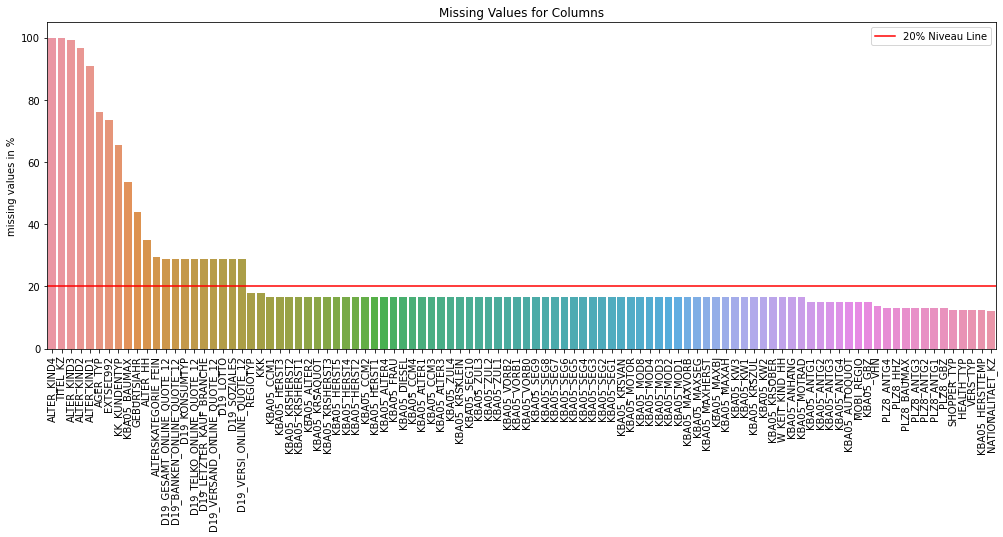

In [55]:
missing_azdias_data = azdias.isna().sum().sort_values(ascending=False).head(100)

plt.figure(figsize=(17,6))
sns.barplot(
    x = missing_azdias_data.index,
    y = missing_azdias_data.values/azdias.shape[0]*100
)
plt.xticks(rotation = 90)
plt.ylabel('missing values in %')
plt.axhline(y = 20, color = 'r', linestyle = '-', label='20% Niveau Line')
plt.title('Missing Values for Columns')
plt.legend()
plt.savefig('plots/missing_values_columns.png', dpi=600)
plt.show()

In [56]:
# columns that can be dropped: We will go with the columns that have missing values less than 20%
missing_azdias_data_pc = azdias.isna().sum().sort_values(ascending=False)/azdias.shape[0]

columns_to_drop = missing_azdias_data_pc[missing_azdias_data_pc>0.2].index
columns_to_drop

Index(['ALTER_KIND4', 'TITEL_KZ', 'ALTER_KIND3', 'ALTER_KIND2', 'ALTER_KIND1',
       'AGER_TYP', 'EXTSEL992', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR',
       'ALTER_HH', 'ALTERSKATEGORIE_FEIN', 'D19_GESAMT_ONLINE_QUOTE_12',
       'D19_BANKEN_ONLINE_QUOTE_12', 'D19_KONSUMTYP',
       'D19_TELKO_ONLINE_QUOTE_12', 'D19_LETZTER_KAUF_BRANCHE',
       'D19_VERSAND_ONLINE_QUOTE_12', 'D19_LOTTO', 'D19_SOZIALES',
       'D19_VERSI_ONLINE_QUOTE_12'],
      dtype='object')

In [57]:
# additionally, we will drop 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015' (since they are too close to 'CAMEO_DEU_2015') 
# and do not deliver more informations

# 'LNR' will also be dropped since its only an index

print(azdias['CAMEO_DEUG_2015'].nunique())
print(azdias['CAMEO_INTL_2015'].nunique())
print(azdias['CAMEO_DEU_2015'].nunique())

18
42
44


In [58]:
# the columns that needs to be dropped are the following
# later they will be useful when we are going to use the function 'clean_df()'

In [59]:
azdias_col_to_drop = list(columns_to_drop) + ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'] + ['LNR'] + ['EINGEFUEGT_AM']

In [60]:
customers_col_to_drop = azdias_col_to_drop + ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']

In [61]:
azdias_clean_col = azdias.drop(azdias_col_to_drop, axis=1)

#### Rows

In [62]:
missing_azdias_data_rows = azdias_clean_col.isna().mean(axis=1)

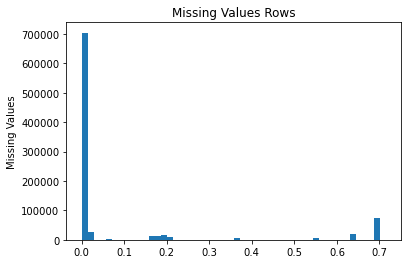

In [63]:
plt.hist(missing_azdias_data_rows, bins=50)
plt.title('Missing Values Rows')
plt.ylabel('Missing Values')
plt.show()

In [64]:
# rows that can be dropped: We will go with the rows that have missing values less than 10%
rows_to_drop = missing_azdias_data_rows[missing_azdias_data_rows>0.1].index

In [65]:
# here we will rebuild the function above within the function 'clean_df()'

In [66]:
azdias_clean_row = azdias_clean_col.drop(rows_to_drop)

In [67]:
azdias_clean_row.shape

(737287, 341)

### 2.E Transformation <a class="anchor" id="Transformation"></a> 

In [68]:
azdias_clean_row.dtypes.value_counts()

float64    254
int64       85
object       2
dtype: int64

In [69]:
# let's go first with the type 'object'

In [70]:
for col in list(azdias_clean_row.select_dtypes(['object']).columns):
    print(col, azdias_clean_row[col].isna().sum())

CAMEO_DEU_2015 3340
OST_WEST_KZ 0


In [71]:
# perfect, now let's have a look at 'OST_WEST_KZ'
# best in this case would be to transform the to binaries

In [72]:
azdias_clean_row['OST_WEST_KZ'].head()

1    W
2    W
3    W
4    W
5    W
Name: OST_WEST_KZ, dtype: object

In [73]:
azdias_clean_row['OST_WEST_KZ'].replace('O', 0, inplace=True)
azdias_clean_row['OST_WEST_KZ'].replace('W', 1, inplace=True)

In [74]:
azdias_clean_row['OST_WEST_KZ'].head()

1    1
2    1
3    1
4    1
5    1
Name: OST_WEST_KZ, dtype: int64

In [75]:
# for 'CAMEO_DEU_2015' it would be great to have dummies
# but first we need to fill the missing values
# for this we will go with the most common value

In [76]:
azdias_clean_row['CAMEO_DEU_2015'] = azdias_clean_row['CAMEO_DEU_2015'].fillna(
    azdias_clean_row['CAMEO_DEU_2015'].value_counts().index[0])

In [77]:
# now we can get the dummies

In [78]:
azdias_clean_row = pd.concat([azdias_clean_row, pd.get_dummies(azdias_clean_row['CAMEO_DEU_2015'])], axis=1)
azdias_clean_row.drop(['CAMEO_DEU_2015'], axis=1, inplace=True)

In [79]:
# now let's have again a look at the types
azdias_clean_row.dtypes.value_counts()

float64    254
int64       86
uint8       44
dtype: int64

In [80]:
# let's have now a look at 'int64'

In [81]:
int64_isnull = []

for col in list(azdias_clean_row.select_dtypes(['int64']).columns):
    int64_isnull.append(azdias_clean_row[col].isna().sum())
    
print(sum(int64_isnull))

0


In [82]:
# there are no missing values for 'int64'

# for the remaining types of 'float64' we will go with the median to fill the missing values
# there should not be much missing data as we have seen before
# therefore going with the median will be an accurate method

In [83]:
for col in list(azdias_clean_row.select_dtypes(['float']).columns):
    azdias_clean_row[col] = azdias_clean_row[col].fillna(azdias_clean_row[col].median())

In [84]:
# checking for missing values

azdias_clean_row.isna().sum().sum()

0

In [85]:
# transforming all data types to 'float'

for col in azdias_clean_row.select_dtypes(['int64', 'uint8']):
    azdias_clean_row[col] = azdias_clean_row[col].astype(float)

In [86]:
# last check for the dtypes

azdias_clean_row.dtypes.value_counts()

float64    384
dtype: int64

In [87]:
azdias_clean_row.shape

(737287, 384)

In [88]:
# all the work above is now summarized in the functino 'clean_df()'

shape old: (891221, 366).


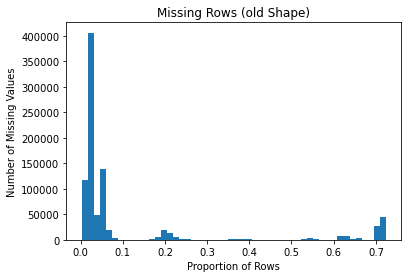

number of nans: 0.
shape new: (737287, 384).
dtypes: float64    384
dtype: int64.


In [89]:
azdias_clean = clean_df(azdias, azdias_col_to_drop)

shape old: (191652, 369).


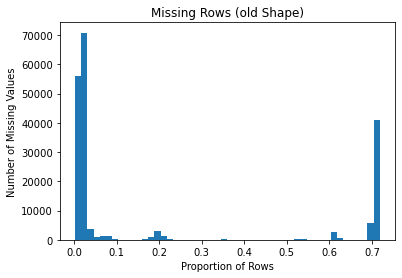

number of nans: 0.
shape new: (134246, 384).
dtypes: float64    384
dtype: int64.


In [90]:
customers_clean = clean_df(customers, customers_col_to_drop)

## 3. Customer Segmentation Report <a class="anchor" id="Segmentation"></a> 

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

This was a very practical guide to do the following analysis. I could use many concept described in the article.

https://realpython.com/k-means-clustering-python

### 3.A PCA <a class="anchor" id="PCA"></a> 

In [68]:
# first thing we want to check is the number of components we can reduce our dataset without loosing too much variance

scaler = StandardScaler()
azdias_clean_test = scaler.fit_transform(azdias_clean)

pca_test = PCA(random_state = 42).fit(azdias_clean_test)

In [69]:
# by try and error we determine

pca_test.explained_variance_ratio_[0:250].sum()

0.9492777722925358

In [70]:
pca_test.explained_variance_ratio_[0:251].sum()

0.9500685537265466

In [71]:
# therefore, I will go only with 251 components, since 95% of the variance is explained by them

In [91]:
# Scale the data
preprocessor = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=251, random_state=42)),
    ]

)

In [92]:
model_prepro = preprocessor.fit(azdias_clean) 

In [74]:
# pd.DataFrame for .sample below
azdias_251 = pd.DataFrame(model_prepro.transform(azdias_clean))
customers_251 = pd.DataFrame(model_prepro.transform(customers_clean))

### 3.B KMeans Clustering <a class="anchor" id="Clustering"></a> 

In [75]:
# determine the parameters for the clustering

kmeans_kwargs = {
    'init': 'k-means++',
    'n_init': 10,
    'max_iter': 300,
    'random_state': 42,
}

In [76]:
# create the list SSE (Sum of Squared Errors) for different k

sse = []

for k in range(1, 26):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(azdias_251.sample(30000, random_state=k))
    sse.append(kmeans.inertia_)

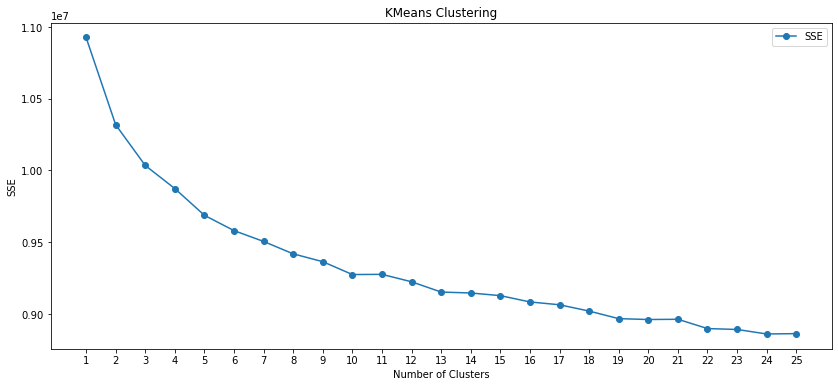

In [77]:
plt.figure(figsize=(14, 6))
plt.plot(range(1, 26), sse, marker='o', label='SSE')
plt.xticks(range(1, 26))
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.title('KMeans Clustering')
plt.legend()
plt.savefig('plots/kmeans_clustering.png', dpi=600)
plt.show()

In [78]:
# therefore, I will go with k=10

In [79]:
n_clusters = 10

In [80]:
# with this pipeline we implement the clusterer

clusterer = Pipeline(
    [
        (
            'kmeans',
            KMeans(
                n_clusters=n_clusters,
                init='k-means++',
                n_init=30,
                max_iter=300,
                random_state=42,
            ),
        ),
    ]
)

In [81]:
# this pipe combines both, the preprocessing and the clustering

pipe = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('clusterer', clusterer),
    ]
)

In [82]:
model_pipe = pipe.fit(azdias_clean)

In [83]:
# by this we build the clustered dataframes

azdias_clustered = pd.DataFrame(model_pipe.predict(azdias_clean), columns = ['Cluster'])
customers_clustered = pd.DataFrame(model_pipe.predict(customers_clean), columns = ['Cluster'])

In [84]:
azdias_clustered.head()

,Cluster
0,1
1,1
2,8
3,2
4,8


In [85]:
# sorted and clustered dataframes to compare the below

azdias_cluster_sort = azdias_clustered['Cluster'].value_counts().sort_index()
customers_cluster_sort = customers_clustered['Cluster'].value_counts().sort_index()

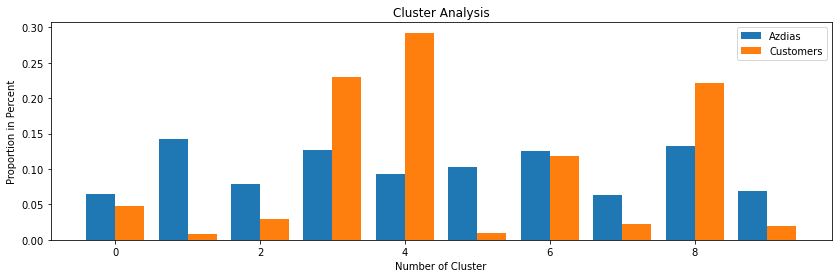

In [86]:
plt.figure(figsize=(14,4))
plt.bar(azdias_cluster_sort.index-0.2, azdias_cluster_sort/azdias_cluster_sort.sum(), width=0.4, label='Azdias')
plt.bar(customers_cluster_sort.index+0.2, customers_cluster_sort/customers_cluster_sort.sum(), width=0.4, label='Customers')
plt.title('Cluster Analysis')
plt.xlabel('Number of Cluster')
plt.ylabel('Proportion in Percent')
plt.legend()
plt.savefig('plots/cluster_analysis.png', dpi=600)
plt.show()

In [87]:
# with the function 'cluster_analysis()' we can now have a closer look on the clusters of interest
# in this case cluster with index 1 and cluster with index 4

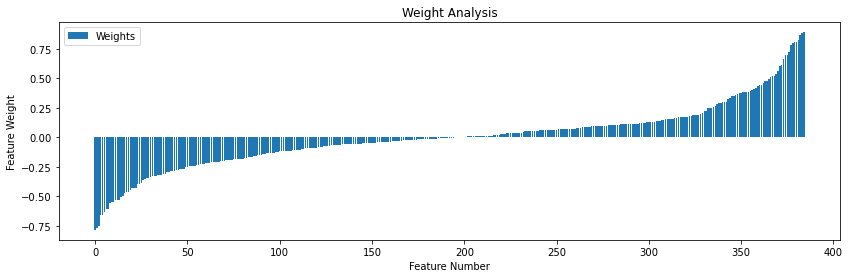

CJT_TYP_5               -0.785399
FINANZ_VORSORGER        -0.765751
ALTERSKATEGORIE_GROB    -0.752754
CJT_TYP_1                0.871601
FINANZ_SPARER            0.885599
FINANZ_UNAUFFAELLIGER    0.890786
dtype: float64

In [88]:
cluster_analysis(1)

What they are **not**:

Care much about Financial Precautions, Young People (younger than 45 years), Low Money Saver, Financially remarkable

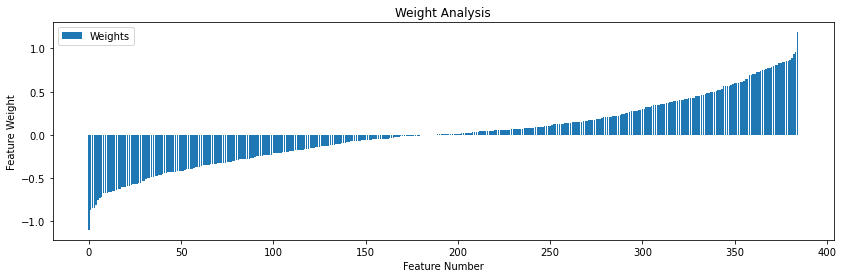

HH_EINKOMMEN_SCORE     -1.098061
KBA13_KMH_180          -0.863109
KKK                    -0.841603
KBA13_KW_0_60          -0.839859
KBA13_KMH_140_210      -0.810568
FINANZ_ANLEGER         -0.753863
REGIOTYP               -0.728216
KBA13_BJ_2000          -0.720016
KBA13_SITZE_5          -0.675271
RT_KEIN_ANREIZ         -0.671355
KBA13_KW_121            0.832105
KBA05_HERST1            0.842634
KBA13_KMH_250           0.846445
LP_STATUS_GROB          0.854613
KBA13_KMH_211           0.856840
KBA13_MERCEDES          0.871723
KBA13_SEG_SPORTWAGEN    0.892779
KBA05_KW3               0.938668
KBA13_HERST_BMW_BENZ    0.953825
GREEN_AVANTGARDE        1.186915
dtype: float64

In [89]:
cluster_analysis(4,10)

What they most likely will be:

High Income, low Share of relatively slow Cars, High Purchasing Power, High Share of powerful Cars, High Share of BMW or Mercedes, Belongs to the green Avantgarde

Financially enough Money to Invest, Upper Class and more likely to be Conservative, Houseowner and Top Earners, 

## 4. Supervised Learning Model <a class="anchor" id="Model"></a> 


Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

### 4.A Load and Clean <a class="anchor" id="Load"></a> 

In [93]:
# load in and clean the training data
mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';', low_memory=False)
mailout_train.drop('Unnamed: 0', axis=1, inplace=True)

In [94]:
mailout_train.shape

(42962, 367)

shape old: (42962, 367).


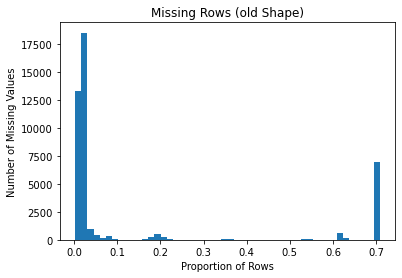

number of nans: 0.
shape new: (33837, 385).
dtypes: float64    385
dtype: int64.


In [95]:
# first we clean the data

replace_by_nan(mailout_train, missing_value_ind_dict)

mailout_train_clean = clean_df(mailout_train, azdias_col_to_drop)

In [96]:
# here we scale the data (but without the column 'RESPONSE')

mailout_train_clean_pre = pd.DataFrame(model_prepro['scaler'].transform(mailout_train_clean.drop(['RESPONSE'], axis=1)), 
                                     columns=mailout_train_clean.drop(['RESPONSE'], axis=1).columns)

In [97]:
# therefore we need to put back 'RESPONSE'

mailout_train_trans = pd.concat([mailout_train_clean_pre.reset_index(drop=True), 
                                 mailout_train_clean[['RESPONSE']].reset_index(drop=True)], axis=1)

In [98]:
mailout_train_trans['RESPONSE'].sum()

416.0

In [99]:
mailout_train_trans.shape

(33837, 385)

### 4.B Choosing the right Classifier <a class="anchor" id="Classifier"></a> 

In [100]:
X = mailout_train_trans.drop(['RESPONSE'], axis=1)
y = mailout_train_trans['RESPONSE']

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

Test Score Learning Curves (RandomForestClassifier): [0.51688685 0.50524094 0.52450513 0.56974359 0.5436301 ]
Test Score Learning Curves (GradientBoostingClassifier): [0.57119243 0.65509182 0.68910158 0.69371122 0.70052294]


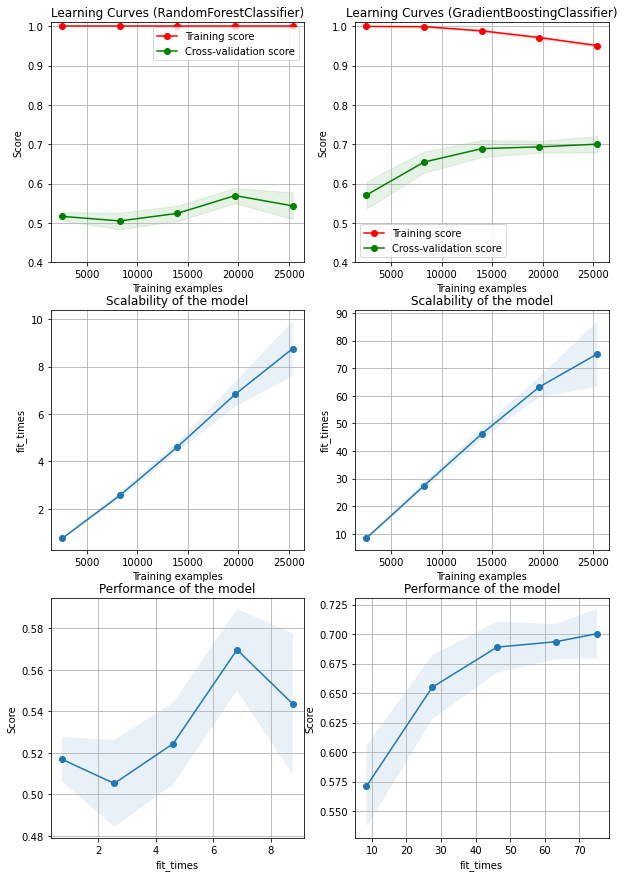

In [156]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

title = "Learning Curves (RandomForestClassifier)"
# Cross validation with 5 iterations to get smoother mean test and train
# score curves, each time with 25% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=5, test_size=0.25, random_state=42)

estimator = RandomForestClassifier()
plot_learning_curve(
    estimator, title, X, y, axes=axes[:, 0], ylim=(0.4, 1.01), cv=cv, n_jobs=-1, scoring='roc_auc'
)

title = "Learning Curves (GradientBoostingClassifier)"
cv = ShuffleSplit(n_splits=5, test_size=0.25, random_state=42)
estimator = GradientBoostingClassifier()
plot_learning_curve(
    estimator, title, X, y, axes=axes[:, 1], ylim=(0.4, 1.01), cv=cv, n_jobs=-1, scoring='roc_auc'
)

plt.savefig('plots/learning_curves.png', dpi=600)
plt.show()

In [100]:
# therefore I will go with the GradientBoostingClassifier
# the RandomForestClassifier seems to produce an overfitting

### 4.C GridSearchCV <a class="anchor" id="GridSearchCV"></a> 

In [131]:
if gridsearch_key:
    gbclf = GradientBoostingClassifier(random_state=42)

    parameters = {
        'loss': ['deviance', 'exponential'],
        'learning_rate': [0.1,0.2],
        'n_estimators': [50,100,200],
        'min_samples_split': [2,3],
        'max_depth': [2,3]
    }

    cv_gbc = GridSearchCV(gbclf, param_grid=parameters, n_jobs=-1)

    cv_gbc.fit(X_train, y_train)

    with open('cv_gbc.pkl', 'wb') as file:
        pickle.dump(cv_gbc, file)

In [133]:
# read the pickle file to save time 

cv_gbc = pd.read_pickle('cv_gbc.pkl')

In [134]:
# the best parameters for the classifier are

cv_gbc.best_params_

{'learning_rate': 0.1,
 'loss': 'exponential',
 'max_depth': 2,
 'min_samples_split': 2,
 'n_estimators': 50}

In [135]:
# define the best classifier

best_gbc_clf = cv_gbc.best_estimator_

In [136]:
best_gbc_clf.score(X_test,y_test)

0.9852202187407626

In [137]:
roc_auc_score(y_test, best_gbc_clf.predict_proba(X_test)[:, 1])

0.6884248424842483

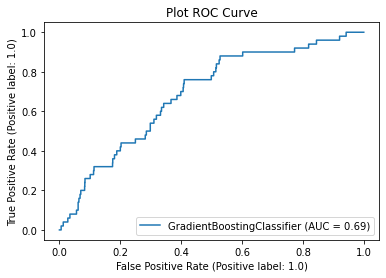

In [153]:
metrics.plot_roc_curve(best_gbc_clf, X_test, y_test) 
plt.title('Plot ROC Curve')
plt.savefig('plots/plot_roc_curve.png', dpi=600)
plt.show()

In [107]:
# the roc_auc_score is 0.69 and therefore slightly better with the additional effort with GridSearchCV (see below)

In [108]:
# Comparison to a Classifier without hypertuning:

In [138]:
normal_gbc_clf=GradientBoostingClassifier(random_state=42)

In [139]:
normal_gbc_clf.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

In [140]:
normal_gbc_clf.score(X_test,y_test)

0.9846290274903932

In [141]:
roc_auc_score(y_test, normal_gbc_clf.predict_proba(X_test)[:, 1])

0.6479147914791479

### 4.D Feature Importance <a class="anchor" id="Importance"></a>

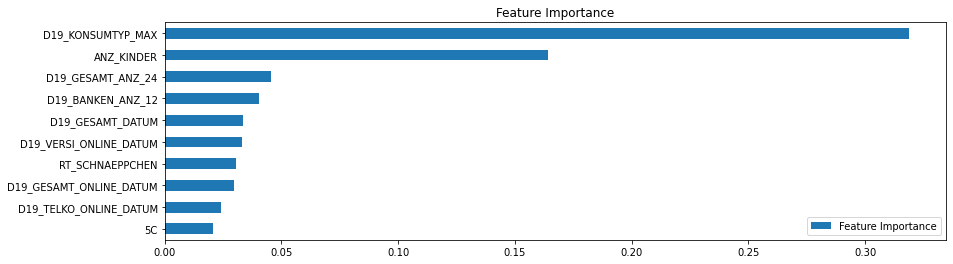

In [142]:
feature_importance = pd.Series(best_gbc_clf.feature_importances_, index = X.columns).sort_values()[-10:].plot(
    kind='barh', figsize=(14,4), label='Feature Importance')
plt.title('Feature Importance')
plt.legend()
plt.savefig('plots/feature_importance.png', dpi=600)
plt.show()

## 5. Kaggle Competition <a class="anchor" id="Kaggle"></a>

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter.

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [106]:
# load in and clean the test data
mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';', low_memory=False)
mailout_test.drop('Unnamed: 0', axis=1, inplace=True)

In [107]:
mailout_test.shape

(42833, 366)

shape old: (42833, 366).


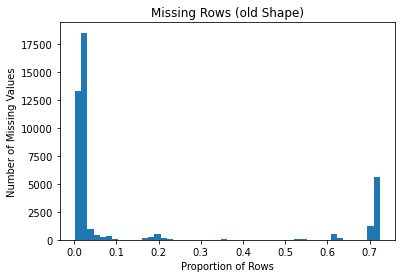

number of nans: 0.
shape new: (42833, 384).
dtypes: float64    384
dtype: int64.


In [108]:
# clean the data

replace_by_nan(mailout_test, missing_value_ind_dict)

mailout_test_clean = clean_df(mailout_test, azdias_col_to_drop, row_level=1)

In [146]:
# predict the 'RESPONSE'

mailout_predict = best_gbc_clf.predict_proba(mailout_test_clean)[:,1]

In [147]:
submission = mailout_test[['LNR']]

In [148]:
submission = pd.concat([submission, pd.DataFrame(mailout_predict, columns=['RESPONSE'])], axis=1)

In [149]:
submission.head()

,LNR,RESPONSE
0,1754,0.016632
1,1770,0.013113
2,1465,0.014022
3,1470,0.016785
4,1478,0.021740


In [150]:
submission.to_csv('submission.csv',index = False)

## 6. Conclusion <a class="anchor" id="conclusion"></a> 

Although the exercise was very taff (especially at the beginning) it was again a great experience for me and my data science journey. Never the less, I would like to mention a few points:

- The data analysis at the beginning was the most difficult part. The cleaning process followed a logical structure, but seemed a bit rudimentary. Apart from deleting columns and rows and transforming some other columns, there would be many more possibilities. One could ask for covariances between features, skewness or more detailed examinations of the deleted columns, just to name a few possibilities. 
- The PCA and clustering are heavily dependent on the previous data cleaning. I am relatively satisfied with this stand-alone part. The elbow plot could have been more powerful, but the clusters generated seem reasonable and a logical consequence of the work done before.
- The process of choosing the right model could certainly have been more detailed and elaborate. I chose to compare only two (but very common) classifiers and compared them head to head. At this point I'm not sure it was the right choice, but with hyperparameter tuning I gained some points for the ROC-AUC metric. Uploading the Kaggle submission worked well, although there is certainly room for improvement for the scoring here too.
    
I am happy with the notebook and the big effort I put into this project. Thank you very much at Udacity for the great project and the help you always provided.


## 7. Appendix <a class="anchor" id="appendix"></a> 

### KFold Cross Validation

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html

In [114]:
from sklearn.model_selection import KFold

kf = KFold(n_splits = 10, shuffle = True)

for train_index, test_index in kf.split(X):
    print("train: " + str(train_index))
    print("test: " + str(test_index))
    print("-----------")
    X_test = X.values[test_index]
    X_train = X.values[train_index] 
    
    y_test = y[test_index]
    y_train = y[train_index]
    
    # RandomForestClassifier trainieren
    model = RandomForestClassifier()
    model.fit(X_train, y_train)

    print(model.score(X_test, y_test))

train: [    0     1     2 ... 33831 33832 33835]
test: [   14    28    63 ... 33833 33834 33836]
-----------
0.9908392434988179
train: [    0     1     2 ... 33834 33835 33836]
test: [    3    12    13 ... 33803 33817 33824]
-----------
0.9855200945626478
train: [    0     1     2 ... 33834 33835 33836]
test: [   21    35    41 ... 33819 33820 33830]
-----------
0.9849290780141844
train: [    0     1     2 ... 33834 33835 33836]
test: [    9    25    27 ... 33815 33823 33825]
-----------
0.9896572104018913
train: [    0     1     2 ... 33834 33835 33836]
test: [   48    50    60 ... 33816 33818 33828]
-----------
0.9875886524822695
train: [    0     3     5 ... 33834 33835 33836]
test: [    1     2     4 ... 33821 33822 33831]
-----------
0.9849290780141844
train: [    0     1     2 ... 33834 33835 33836]
test: [    8    18    22 ... 33799 33808 33812]
-----------
0.9899527186761229
train: [    1     2     3 ... 33833 33834 33836]
test: [    0    11    38 ... 33829 33832 33835]
-------